In [67]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, CSVLogger, TensorBoard
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from models.keras_ssd7 import build_model
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.data_augmentation_chain_variable_input_size import DataAugmentationVariableInputSize
from data_generator.data_augmentation_chain_constant_input_size import DataAugmentationConstantInputSize
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation

In [7]:
img_height = 400 # Height of the input images
img_width = 600 # Width of the input images
img_channels = 3 # Number of color channels of the input images
n_classes = 43 # Number of positive classes
scales = [0.08, 0.16, 0.32, 0.64, 0.96] # An explicit list of anchor box scaling factors. If this is passed, it will override `min_scale` and `max_scale`.
aspect_ratios = [0.5, 1.0, 2.0] # The list of aspect ratios for the anchor boxes
two_boxes_for_ar1 = True # Whether or not you want to generate two anchor boxes for aspect ratio 1
steps = None # In case you'd like to set the step sizes for the anchor box grids manually; not recommended
offsets = None # In case you'd like to set the offsets for the anchor box grids manually; not recommended
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [1.0, 1.0, 1.0, 1.0] # The list of variances by which the encoded target coordinates are scaled
normalize_coords = True # Whether or not the model is supposed to use coordinates relative to the image size

In [8]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = build_model(image_size=(img_height, img_width, img_channels),
                    n_classes=n_classes,
                    mode='training',
                    l2_regularization=0.0005,
                    scales=scales,
                    aspect_ratios_global=aspect_ratios,
                    aspect_ratios_per_layer=None,
                    two_boxes_for_ar1=two_boxes_for_ar1,
                    steps=steps,
                    offsets=offsets,
                    clip_boxes=clip_boxes,
                    variances=variances,
                    normalize_coords=normalize_coords)

# 2: Optional: Load some weights

# model.load_weights('./ssd7_weights.h5', by_name=True)

# 3: Instantiate an Adam optimizer and the SSD loss function and compile the model

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=5e-4)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss, metrics=['accuracy'])

In [9]:
# 1: Instantiate two `DataGenerator` objects: One for training, one for validation.

# Optional: If you have enough memory, consider loading the images into memory for the reasons explained above.

train_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)

# 2: Parse the image and label lists for the training and validation datasets.

# TODO: Set the paths to your dataset here.

# Images
images_dir = 'data/Full/'
# train_images_dir = 'data/Train/'
# test_images_dir = 'data/Test/'
# train_images_dir = 'data/car_data/train/'
# test_images_dir = 'data/car_data/validation/'

# Ground truth
# labels_filename = 'data/gt_png.txt'
train_labels_filename = 'data/train.txt'
val_labels_filename   = 'data/test.txt'
# train_labels_filename = 'data/car_data/anno_train.txt'
# val_labels_filename   = 'data/car_data/anno_test.txt'

train_dataset.parse_csv(images_dir=images_dir,
                        labels_filename=train_labels_filename,
                        input_format=['image_name', 'xmin', 'ymin', 'xmax', 'ymax', 'class_id'], # This is the order of the first six columns in the CSV file that contains the labels for your dataset. If your labels are in XML format, maybe the XML parser will be helpful, check the documentation.
                        include_classes='all')

val_dataset.parse_csv(images_dir=images_dir,
                      labels_filename=val_labels_filename,
                      input_format=['image_name', 'xmin', 'ymin', 'xmax', 'ymax', 'class_id'],
                      include_classes='all')

# Optional: Convert the dataset into an HDF5 dataset. This will require more disk space, but will
# speed up the training. Doing this is not relevant in case you activated the `load_images_into_memory`
# option in the constructor, because in that cas the images are in memory already anyway. If you don't
# want to create HDF5 datasets, comment out the subsequent two function calls.

# train_dataset.create_hdf5_dataset(file_path='dataset_udacity_traffic_train.h5',
#                                   resize=False,
#                                   variable_image_size=True,
#                                   verbose=True)

# val_dataset.create_hdf5_dataset(file_path='dataset_udacity_traffic_val.h5',
#                                 resize=False,
#                                 variable_image_size=True,
#                                 verbose=True)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Loading images into memory: 100%|████████████████████████| 75/75 [00:00<00:00, 86.74it/s]
Number of images in the training dataset:	   666
Number of images in the validation dataset:	    75


In [258]:
# 3: Set the batch size.

batch_size = 16
resize = Resize(height=img_height, width=img_width)

# 4: Define the image processing chain.

data_augmentation_chain = DataAugmentationConstantInputSize(
                                                            random_brightness=(-0.9, 0.1, 0.5),
                                                            random_contrast=(0, 0.1, 0),
                                                            random_saturation=(0, 0.1, 0),
                                                            random_hue=(0, 0),
                                                            random_translate=((0,0), (0,0), 0),
                                                            random_scale=(0.99, 5.0, 1),
                                                            random_flip=0,
                                                            n_trials_max=3,
                                                            clip_boxes=True,
                                                            overlap_criterion='area',
                                                            bounds_box_filter=(0.3, 1.0),
                                                            bounds_validator=(0.5, 1.0),
                                                            n_boxes_min=1)

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.

# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('classes4').output_shape[1:3],
                   model.get_layer('classes5').output_shape[1:3],
                   model.get_layer('classes6').output_shape[1:3],
                   model.get_layer('classes7').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_global=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.3,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[data_augmentation_chain,
                                                          resize],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)


In [267]:
# test_generator = train_dataset.generate(batch_size=10,
#                                          shuffle=True,
#                                          transformations=[data_augmentation_chain,
#                                                           resize],
#                                          label_encoder=ssd_input_encoder,
#                                          returns={'processed_images',
#                                                   'encoded_labels',
#                                                  'original_images'},
#                                          keep_images_without_gt=False)
# batch_images, batch_labels, origin_image= next(test_generator)

In [268]:
# plt.figure(figsize=(20,12))
# plt.imshow(origin_image[4])

In [269]:
# plt.figure(figsize=(20,12))
# plt.imshow(batch_images[4])

In [ ]:
## Define model callbacks.

# TODO: Set the filepath under which you want to save the weights.
model_checkpoint = ModelCheckpoint(filepath='ssd7_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)

csv_logger = CSVLogger(filename='ssd7_training_log.csv',
                       separator=',',
                       append=True)

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0.0,
                               patience=50,
                               verbose=1)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.1,
                                         patience=20,
                                         verbose=1,
                                         epsilon=0.001,
                                         cooldown=0,
                                         min_lr=0)

tensorboard = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                batch_size=16,
                write_graph=True,
                write_grads=False,
                write_images=True,
                embeddings_freq=0, 
                embeddings_layer_names=None, 
                embeddings_metadata=None
)

callbacks = [model_checkpoint,
             csv_logger,
             early_stopping,
             tensorboard,
             reduce_learning_rate]

In [8]:
# TODO: Set the epochs to train for.
# If you're resuming a previous training, set `initial_epoch` and `final_epoch` accordingly.
initial_epoch   = 0
final_epoch     = 500
steps_per_epoch = ceil(train_dataset_size/batch_size)

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=ceil(val_dataset_size/batch_size),
                              initial_epoch=initial_epoch)

Epoch 1/500
42/42 [==============================] - 57s 1s/step - loss: 21.5194 - acc: 9.7864e-04 - val_loss: 17.9482 - val_acc: 0.0012

Epoch 00001: val_loss improved from inf to 17.94815, saving model to ssd7_epoch-01_loss-21.5565_val_loss-17.9482.h5
Epoch 2/500
42/42 [==============================] - 53s 1s/step - loss: 15.6171 - acc: 0.0011 - val_loss: 15.9978 - val_acc: 0.0013

Epoch 00002: val_loss improved from 17.94815 to 15.99784, saving model to ssd7_epoch-02_loss-15.6291_val_loss-15.9978.h5
Epoch 3/500
42/42 [==============================] - 54s 1s/step - loss: 13.4200 - acc: 0.0012 - val_loss: 13.9732 - val_acc: 0.0013

Epoch 00003: val_loss improved from 15.99784 to 13.97324, saving model to ssd7_epoch-03_loss-13.4327_val_loss-13.9732.h5
Epoch 4/500
42/42 [==============================] - 55s 1s/step - loss: 11.0718 - acc: 0.0012 - val_loss: 11.7170 - val_acc: 0.0013

Epoch 00004: val_loss improved from 13.97324 to 11.71696, saving model to ssd7_epoch-04_loss-11.0830_v

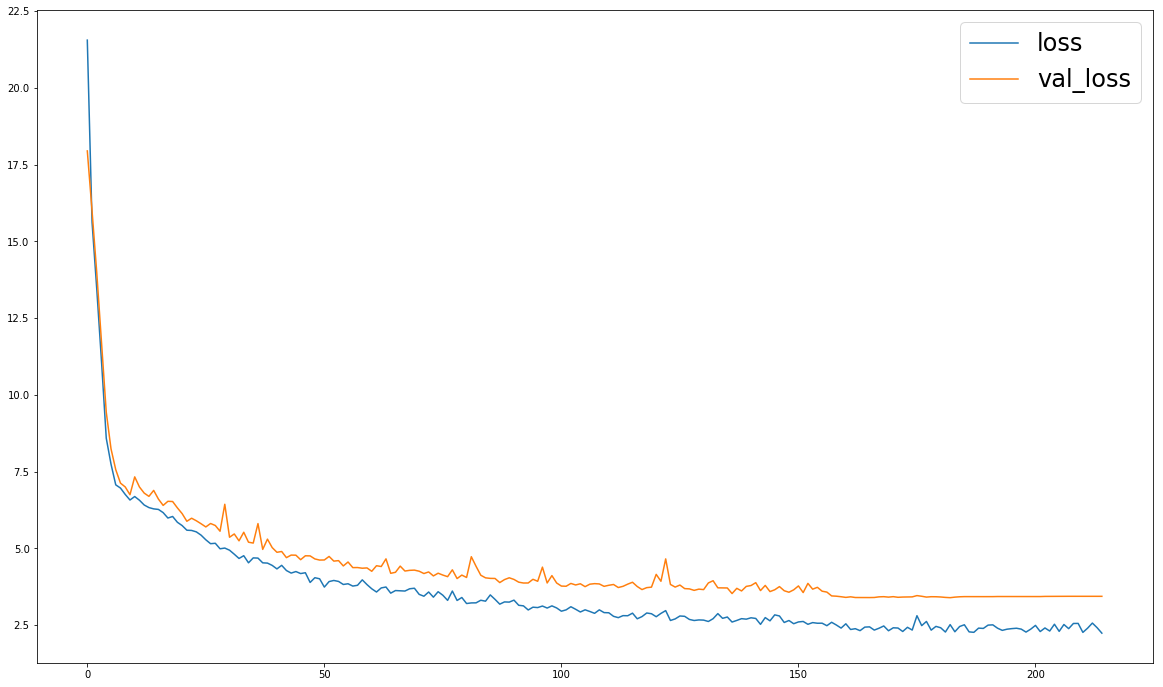

In [9]:
fig = plt.figure(figsize=(20,12))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='upper right', prop={'size': 24})
fig.savefig('loss.png')

from data_generator.object_detection_2d_data_generator import DataGenerator
predict_generator = train_dataset.generate(transformations=[re],
                                           batch_size=1,
                                           shuffle=True,
                                           label_encoder=None,
                                           returns={'processed_images',
                                                    'processed_labels',
                                                    'filenames',
                                                    'original_images',
                                                    'original_labels'},
                                           keep_images_without_gt=False)
batch_images, batch_annotations, filenames, original_images, original_annotations = next(predict_generator)

In [200]:
# 1: Set the generator for the predictions.

predict_generator = val_dataset.generate(batch_size=val_dataset_size,
                                         shuffle=False,
                                         transformations=[resize],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                    'processed_labels',
                                                    'filenames',
                                                    'original_images',
                                                    'original_labels'},
                                         keep_images_without_gt=False)

In [274]:
original_annotations[3]

array([[ 13, 731, 422, 772, 459],
       [ 40, 734, 463, 767, 497]])

In [276]:
batch_images, batch_labels, batch_filenames, original_images, original_annotations= next(predict_generator)
y_pred = model.predict(batch_images)
y_pred_decoded = decode_detections(y_pred,
                               confidence_thresh=0.5,
                               iou_threshold=0.45,
                               top_k=200,
                               normalize_coords=normalize_coords,
                               img_height=img_height,
                               img_width=img_width)

for i in original_annotations[i]:
    y_true = np.array(i[0])
y_true = np.array(original_annotations[0][0][0])
if len(y_pred_decoded[0]) == 0:
    y_pred = np.array(-1)
else:
    for j in y_pred_decoded[i]:
        y_pred = np.array(j[0])
        
for i in range(1, val_dataset_size):
    for j in original_annotations[i]:
        y_true = np.hstack((y_true, j[0]))
    if len(y_pred_decoded[i]) == 0:
        y_pred = np.hstack((y_pred, -1))
    else:
        for j in y_pred_decoded[i]:
            y_pred = np.hstack((y_pred, j[0]))
    

In [277]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

ValueError: Found input variables with inconsistent numbers of samples: [127, 161]

In [167]:
# 2: Generate samples

batch_images, batch_labels, batch_filenames, original_images, original_annotations= next(predict_generator)

i = 0 # Which batch item to look at

print("Image:", batch_filenames[i])
print()
# 3: Make a prediction

y_pred = model.predict(batch_images)

# 4: Decode the raw prediction `y_pred`

y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.45,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Ground truth boxes:\nclass, xmin, ymin, xmax, ymax")
print(batch_labels[i])
print("\nPredicted boxes:")
print('class, conf, xmin, ymin, xmax, ymax')
print(y_pred_decoded[i])

Ground truth boxes:
class, xmin, ymin, xmax, ymax
[[ 21 314 246 323 256]]

Predicted boxes:
class, conf, xmin, ymin, xmax, ymax
[]


In [ ]:
y_pred_decoded[i]

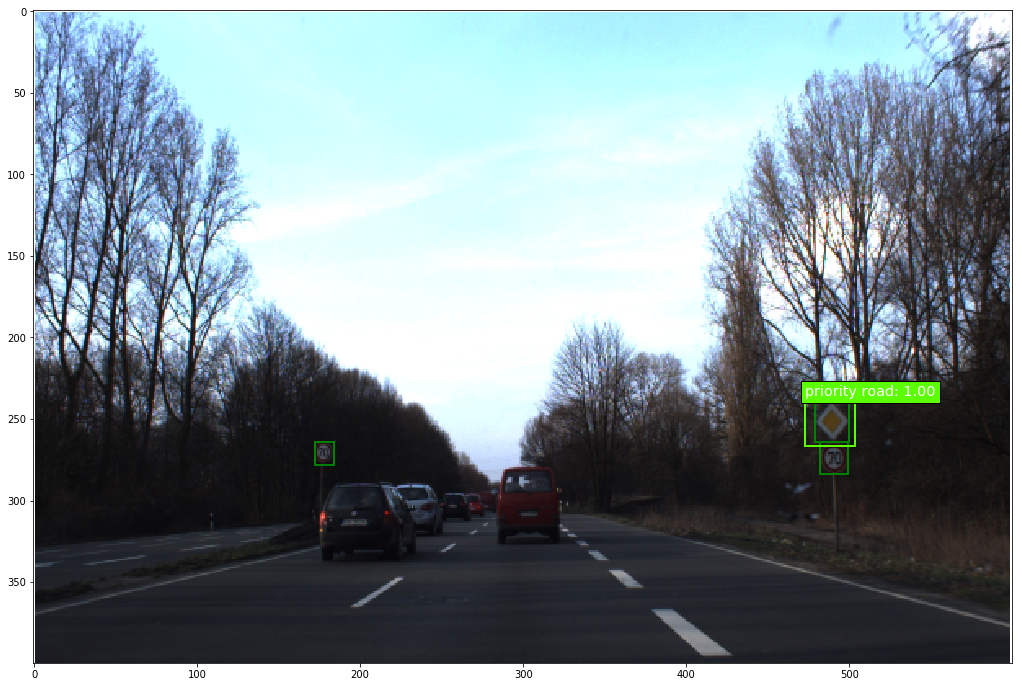

In [155]:
# 5: Draw the predicted boxes onto the image

plt.figure(figsize=(20,12))
plt.imshow(batch_images[i])

current_axis = plt.gca()

colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist() # Set the colors for the bounding boxes
classes = pd.read_csv('data/classes.txt') # Just so we can print class names onto the image instead of IDs

# Draw the ground truth boxes in green (omit the label for more clarity)
for box in batch_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes.loc[int(box[0]),'class_name'])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    #current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

# Draw the predicted boxes in blue
for box in y_pred_decoded[i]:
    xmin = box[-4]
    ymin = box[-3]
    xmax = box[-2]
    ymax = box[-1]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes.loc[int(box[0]),'class_name'], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})